In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def get_act_regions(mat):
    return np.unique(mat, axis=0).shape[0]

def sval_metrics(mat):
    """For computational efficiency, just compute svd once"""
    svals = np.linalg.svd(mat, compute_uv=False)
    regions = sum(svals > 0)

    schatten1 = sum(svals)
    n = mat.shape[0]
    evals = svals**2
    vec = np.asarray([
        i / n + np.sqrt(np.sum(evals[i:]) / n) for i in range(len(evals)+1)
    ])
    hstar = min(vec)

    return regions, hstar, schatten1

In [3]:
df_mat = []
for run in range(10):
    results = np.load(f'results_train_test/results_{run}.npz', allow_pickle=True)
    for arch in ['w', 'd']:
        d = results[f'result_{arch}'].flatten()[0]
        for n_par, error_train, error_test, loss_train, loss_test, *mats in zip(
            d['n_pars'], d['train_gen_err'], d['test_gen_err'], d['train_loss'], d['test_loss'],
            d['matrices']['0/1'], d['matrices_test']['0/1'], d['pen_matrices']['0/1'], d['pen_matrices_test']['0/1'],
            d['matrices']['true_label'], d['pen_matrices']['true_label'],
            d['matrices']['est_label'], d['matrices_test']['est_label'], d['pen_matrices']['est_label'], d['pen_matrices_test']['est_label'],
            d['matrices']['est_poster'], d['matrices_test']['est_poster'], d['pen_matrices']['est_poster'], d['pen_matrices_test']['est_poster']
        ):
            row = [
                'width' if arch == 'w' else 'depth', n_par, run,
                error_train, error_test, loss_train, loss_test,
            ]
            for mat in mats:
                regions, hstar, schatten1 = sval_metrics(mat)
                row += [regions, hstar, schatten1]
            df_mat.append(row)

In [55]:
np.sum(np.abs(d['pen_matrices']['0/1'][-1] - (1 - (d['pen_matrices']['true_label'][-1] == 0))))

0.0

In [65]:
d['pen_matrices_test']['est_poster'][-1]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.67371762],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.36506224],
       [ 0.        ,  0.        ,  0.        , ...,  0.86099267,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.65656364],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.75482106],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.89556128]])

In [66]:
d['pen_matrices']['est_poster'][-1]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.74527144],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.53162336],
       [ 0.        ,  0.        ,  0.        , ..., -0.89556128,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.9997263 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.58466077],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.98236024]])

In [35]:
columns = [
    'Architecture', 'n_parameters', 'run',
    'error_train', 'error_test',
    'loss_train', 'loss_test',
]
for encoding in ['01', 'true_labels', 'pred_labels', 'posteriors']:
    for mat_type in ['mat_train', 'mat_test', 'pen_train', 'pen_test']:
        if 'test' in mat_type and encoding == 'true_labels':
            continue
        else:
            tag = mat_type + '-' + encoding
            columns += [f'n_regions-{tag}', f'h*-{tag}', f'Schatten1-{tag}']


df = pd.DataFrame(
    data = df_mat,
    columns=columns
)

In [36]:
df.to_csv('./results_train_test/results_table.csv')

In [48]:
row_y = [
    ['error_train', 'error_test'],
    ['loss_train', 'loss_test'],
    ['n_regions-mat_train-01', 'n_regions-mat_test-01'],
    ['h*-mat_train-01', 'h*-mat_test-01'],
    ['Schatten1-mat_train-01', 'Schatten1-mat_test-01'],
    ['n_regions-pen_train-01', 'n_regions-pen_test-01'],
    ['h*-pen_train-01', 'h*-pen_test-01'],
    ['Schatten1-pen_train-01', 'Schatten1-pen_test-01'],
]

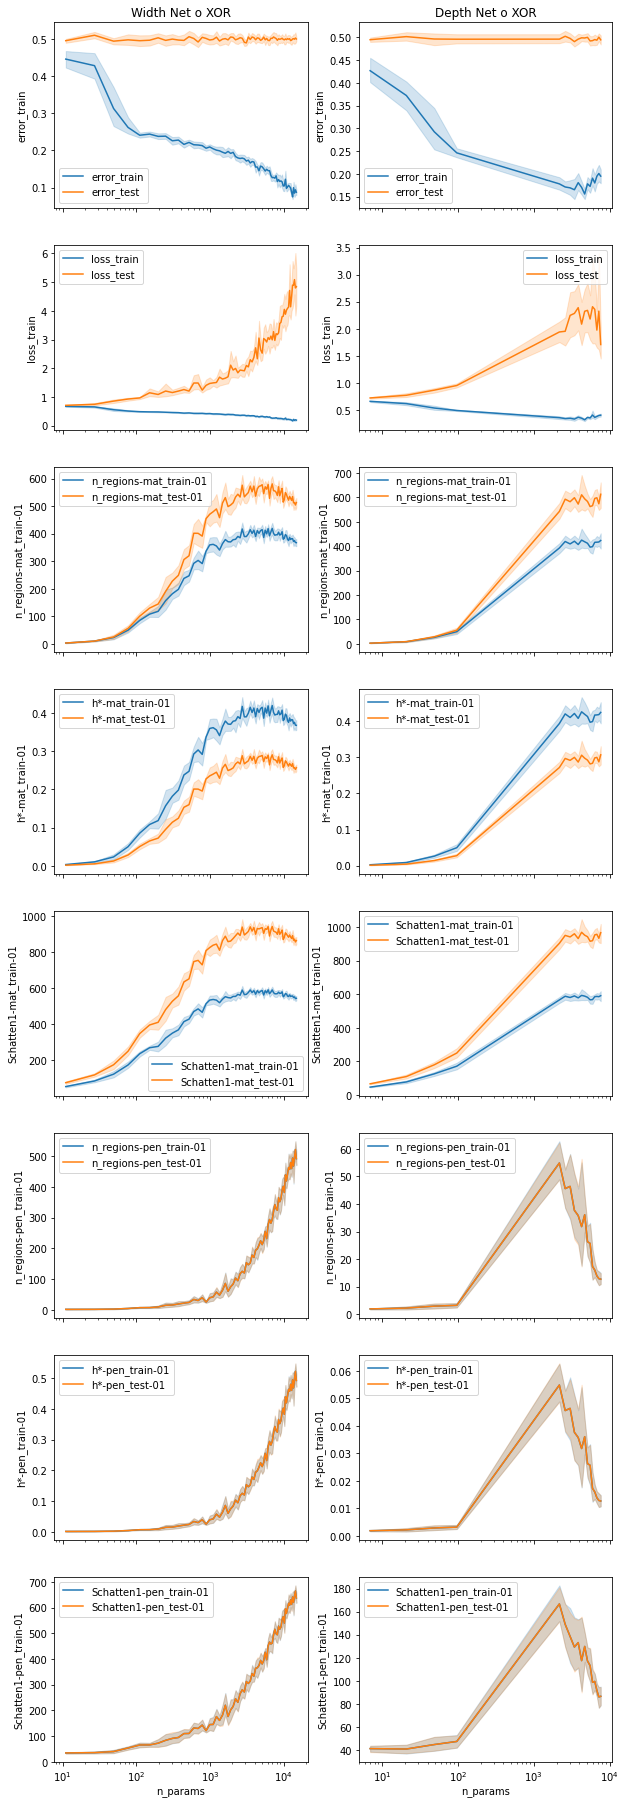

In [49]:
fig, axes = plt.subplots(len(row_y), 2, figsize=(10, 4*len(row_y)), sharex='col')#, sharex='col')#, sharey='row')
for col, arch in enumerate(['width', 'depth']):
    for row, ys in enumerate(row_y):
        ax = axes[row, col]
        for y in ys:
            sns.lineplot(
                data=df[df['Architecture'] == arch],
                x='n_parameters', y=y,
                ax=ax, label=y)
axes[0, 0].set_title('Width Net o XOR')
axes[0, 1].set_title('Depth Net o XOR')
for ax in (axes[-1, 0], axes[-1, 1]):
    ax.set_xlabel('n_params')
    ax.set_xscale('log')